# Исследование закономерностей, определяющих успешность игры

У нас есть данные из интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

**Цель исследования** - нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Гипотезы:**
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

**Описание данных:**
Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Изучение данных

Импортируем все библиотеки Pandas, которые нам могут пригодиться:

In [260]:
import pandas as pd
import warnings 
warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [261]:
dataset=pd.read_csv('games.csv')

In [262]:
dataset.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
14118,"My World, My Way (US sales)",DS,2008.0,Role-Playing,0.04,0.00,0.00,0.00,NaN,NaN,NaN
894,Mortal Kombat vs. DC Universe,X360,2008.0,Fighting,1.53,0.23,0.00,0.16,72.0,7.5,T
11881,SD Gundam: Gashapon Wars,GC,2005.0,Strategy,0.00,0.00,0.07,0.00,NaN,NaN,NaN
3129,Crash Bandicoot Purple: Ripto's Rampage,GBA,2004.0,Platform,0.46,0.17,0.00,0.01,67.0,6.6,E
3912,Disney's Kim Possible: Revenge of Monkey Fist,GBA,2002.0,Platform,0.37,0.14,0.00,0.01,62.0,8.8,E
8638,Burger Island,DS,2008.0,Action,0.15,0.00,0.00,0.01,NaN,tbd,E
3448,Skylanders SWAP Force,WiiU,2013.0,Platform,0.38,0.15,0.00,0.05,89.0,6,E10+
15577,Kung Fu Panda: Showdown of Legendary Legends,PS3,2015.0,Action,0.00,0.02,0.00,0.00,NaN,tbd,E10+
5018,Saints Row: The Third,PC,2011.0,Action,0.16,0.16,0.00,0.06,84.0,8.1,M
11909,Circus Maximus: Chariot Wars,XB,2002.0,Racing,0.05,0.02,0.00,0.00,67.0,5,T


* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [263]:
dataset.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [264]:
dataset.shape

(16715, 11)

In [265]:
dataset.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Выводы

1. Первое, что необходимо поправить ( то что бросается в глаза) - запишем название столбцов в нижнем регистре.
2. В столбце Genre - есть два пропуска. В данном конкретном случае можно посмотреть, что за игры и поставить вручную ( но только в этом случае, в целом так делать не эффективно).
3. Пропуски в остальных столбцах посмотрим и подумаем чем заменить.
4. Года выхода игр и оценки критиков необходимо будет привести к целому числу.
5. Оценки пользователя надо будет привести к float64.

## Предобработка данных

### Стиль заголовков

Приведем наименование столбцов к нижнему регистру:

In [266]:
dataset=dataset.rename(columns={'Name':'name', 'Platform':'platform', 'Year_of_Release':'year_of_release', 
                                'Genre':'genre', 'NA_sales':'na_sales', 'EU_sales':'eu_sales', 'JP_sales':'jp_sales', 
                                'Other_sales':'other_sales', 'Critic_Score':'critic_score', 'User_Score':'user_score', 
                                'Rating':'rating'})
dataset.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Теперь написание наименой столбцов выглядит красиво и в соответствии с общепринятыми правила.

### Обработка дубликатов и пропусков

Проверим есть ли у нас явные дубликаты:

In [267]:
print(f"Дубликатов в таблице: {dataset.duplicated().sum()}")

Дубликатов в таблице: 0


Проверим не повторяются ли жанры в нашей подборке:

In [268]:
genre=dataset['genre'].sort_values(ascending=True)
genre.unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy', nan], dtype=object)

Отлично явных и скрытых дубикатов не найдено. Двигаемся дальше.

Посмотрим сколько пропусков у нас:

In [269]:
dataset.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Пропуски по столбцам critic_score, user_score - боюсь что мы не сможем заменить ( можно было бы заменить медианой по жанру или платформе - но считаю что это сильно исказить реальность, или добавить руками так как данные по этим играм есть в общем доступе, но это слишком накладно, предлагаю оставить так). Пропуски по столбцу rating и year_of_release - можно конечно тоже в интернете найти, но это так же трудозатратно - предлагаю также оставить как есть (year_of_release - я было подумал, что можно найти еще одним способом: явно игры выходили на других платформах, но годы выхода на разных платформах могут оличаться на несколько лет, например Overwatch  вышел на ПК в 2016, а на Нинтендо 2019 г. ( милый шутер - мультяшшные пострелушки после работы самое то, мне нравится :-)). Два пропуска по столбцу genre и столбцу name - подозрительно, проверим не совпадают ли они:

In [270]:
display(dataset[dataset['name'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Ага, значит получается так что возможно при записи данных произошел сбой и не записалось имя игры и как следствие часть данных по игре было потеряно ( по хорошему надо бы уточнить у разработчиков в чем причина такой записи, но увы - у нас нет такой возможности). По данным двум играм очень много пропусков, предлагаю эти две строки удалить (2 записи из 16 тыс. записей роли не сыграют):

In [271]:
dataset.dropna(subset=['name'], inplace=True)
dataset.shape

(16713, 11)

Посмотрим на другие столбцы краем глаза:

In [272]:
display(dataset['critic_score'].value_counts())

70.0    256
71.0    254
75.0    245
78.0    240
73.0    238
       ... 
20.0      3
21.0      1
17.0      1
22.0      1
13.0      1
Name: critic_score, Length: 82, dtype: int64

In [273]:
display(dataset['user_score'].value_counts())

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

tbd - рейтин будет определен ( на момент формирования датасета рейтин был неизвестен я так понимаю). Так как нам в дальнейшем нам надо будет значения по данному стобцу преобразовать в значение float, предлагаю заменить tbd пустыми значениями. Эти значения также предлагаю пока оставить как есть.

In [274]:
dataset.loc[dataset['user_score']=="tbd", 'user_score']=np.nan
dataset.tail()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN


In [275]:
display(dataset['user_score'].value_counts())

7.8    324
8      290
8.2    282
8.3    254
8.5    253
      ... 
1.5      2
0.3      2
1.1      2
0        1
9.7      1
Name: user_score, Length: 95, dtype: int64

In [276]:
display(dataset['rating'].value_counts())

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Пропуски в столбцах critic_score, user_score, rating и year_of_release все-таки оставим, нет возможности их исправить.

### Замена типа данных

Приведем значения в стобце year_of_release и critic_score к целому значению:

In [277]:
dataset['year_of_release'] = dataset['year_of_release'].astype('Int64')
dataset['critic_score'] = dataset['critic_score'].astype('Int64')

Приведем значение в стобце user_score к значению float:

In [278]:
dataset['user_score'] = dataset['user_score'].astype('float64')

### Расчеты и добавление данных в таблицу

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец:

In [279]:
dataset['all_sales'] = dataset['na_sales'] + dataset['eu_sales'] + dataset['jp_sales'] + dataset['other_sales']

### Вывод

* Мы привели написание столбцов к нижнему регистру: теперь это смотрится аккуратно и красиов.
* Выяснили, что дубликатов и неявных дубликатов нет.
* Превели необходимы нам столбцы к нужным типам: float64 И Int64.
* Пропуски по столбцам critic_score, user_score, rating и year_of_release оставили как есть, так как не нашли адекватной возможности найти замену пропускам.
* Посчитали полную выручку по всем каналам продаж для каждой игры

## Исследовательский анализ данных

### Выпуск игр по годам

Посмотрим как выпускались игры по годам:

In [280]:
dataset_year_of_release = dataset.groupby('year_of_release')['name'].count().reset_index()
dataset_year_of_release.columns = ['years', 'sum']

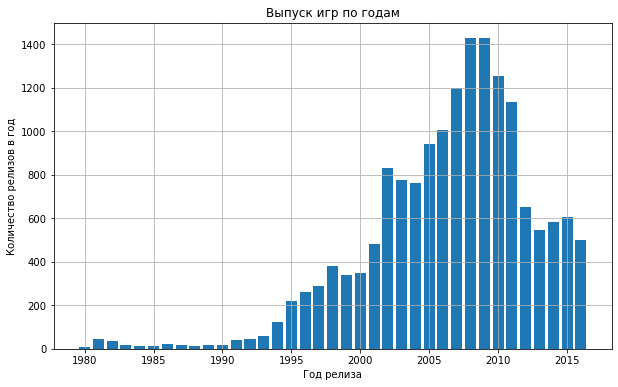

In [281]:
fig, ax = plt.subplots()
ax.bar(dataset_year_of_release['years'], dataset_year_of_release['sum'])
plt.xlabel('Год релиза')
plt.ylabel('Количество релизов в год')
plt.grid()
plt.title('Выпуск игр по годам')
fig.set_figwidth(10)    
fig.set_figheight(6)  
plt.show()

Изучив гисторграмму выпуска игр по годам можно сказать следующее: резкое увеличение выпуска игр началось с 1995 года и продолжалось до 2009, игры начинают оккупацию свободного времени людей. С 2011 года выпуск игр падает и с 2012 года входит в стагнацию. Если посмотреть с целом на рост то заметны две точки роста: 1995 год и 2002 год.

Посмотрим так же динамику продаж игр по годам:

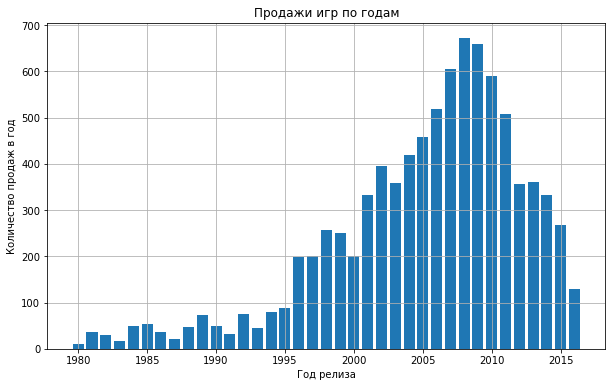

,years,sum
0,1980,11.38
1,1981,35.68
2,1982,28.88
3,1983,16.80
4,1984,50.35


In [282]:
dataset_year_of_release_sum = dataset.groupby('year_of_release')['all_sales'].sum().reset_index()
dataset_year_of_release_sum.columns = ['years', 'sum']
fig, ax = plt.subplots()
ax.bar(dataset_year_of_release_sum['years'], dataset_year_of_release_sum['sum'])
plt.xlabel('Год релиза')
plt.ylabel('Количество продаж в год')
plt.grid()
plt.title('Продажи игр по годам')
fig.set_figwidth(10)    
fig.set_figheight(6)  
plt.show()
dataset_year_of_release_sum.head()

Количество проданных копий игр преследует туже тенденцию, что и выпуск игры и это логично: бум начаниется с 1996 года и длится до 2008 г. Потом происходит постепенное снижение.

Предлагаю еще посмотреть корреляцию между выпуском и продажей игр.

,years,sum,kol
years,1.000000,0.782767,0.792978
sum,0.782767,1.000000,0.981406
kol,0.792978,0.981406,1.000000


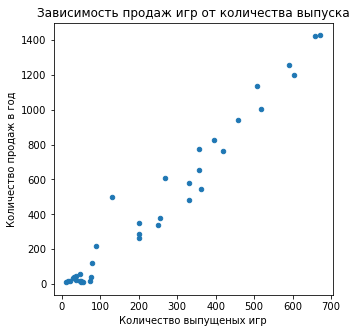

In [283]:
dataset_new=dataset_year_of_release_sum
dataset_new['kol']=dataset_year_of_release['sum']
dataset_new.plot(x='sum', y='kol', kind='scatter', figsize=(5, 5));
plt.xlabel('Количество выпущеных игр')
plt.ylabel('Количество продаж в год')
plt.title('Зависимость продаж игр от количества выпуска');
dataset_new.corr()

Ожидаемо, что прослеживается взаимосвязь ( и достаточно хорошая) по всем показателям. Каждый последующий год растет количество продаж и количество выпущенных игр. Так же высокая корелляция наблюдается между количеством выпущенных игр и количеством проданных копий.

В целом можно сказать, что можно взять для наблюдения период с 1996 год и по 2017 год. Значения до 1996 года крайне малы.
Предлагаю далее отсечь данные до 1995 года и работать уже с этими данными.

In [284]:
dataset=dataset[dataset['year_of_release'] > 1996]

### Динамика продаж игр по платформам

Посмотрим на самые популяные платформы за все года:

In [285]:
pivot_dataset_platform=pd.pivot_table(dataset,index=['platform'], values='all_sales', aggfunc='sum')
pivot_dataset_platform=pivot_dataset_platform.reindex(pivot_dataset_platform['all_sales'].sort_values(ascending=False).index)
display(pivot_dataset_platform.head(15))

,all_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,590.89
PS4,314.14
GBA,312.88
PSP,289.53


Как мы видим у нас представлены платформы по убываю, с наибольшим количество продаж игр. Предлагаю посмотреть продажи конкретно по каждой платформы из курпнейщих, и обязательно включить версия для настольного ПК, странно что он не в лидерах по продажам.

Text(0.5, 1.0, 'Гистограмма продажа игр на платформе PS2')

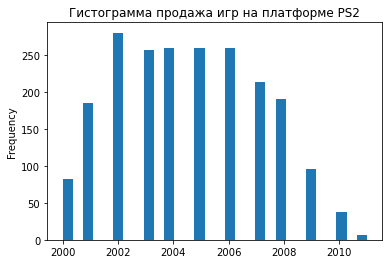

In [286]:
data_PS2 = dataset[dataset['platform'] == 'PS2']
data_PS2.groupby('year_of_release')['all_sales'].agg('sum')
data_PS2['year_of_release'].plot(kind='hist', bins=30).set_title('Гистограмма продажа игр на платформе PS2')

Text(0.5, 1.0, 'Гистограмма продажа игр на платформе X360')

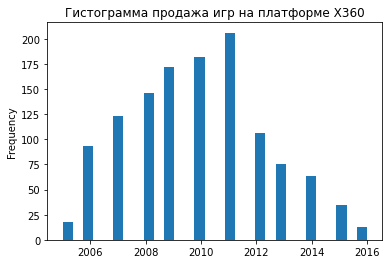

In [287]:
data_X360 = dataset[dataset['platform'] == 'X360']
data_X360.groupby('year_of_release')['all_sales'].agg('sum')
data_X360['year_of_release'].plot(kind='hist', bins=30).set_title('Гистограмма продажа игр на платформе X360')

Text(0.5, 1.0, 'Гистограмма продажа игр на платформе PS3')

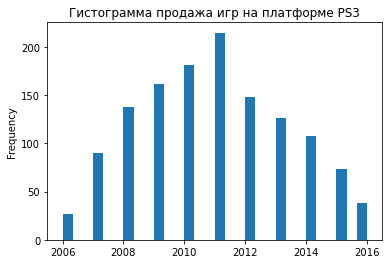

In [288]:
data_PS3 = dataset[dataset['platform'] == 'PS3']
data_PS3.groupby('year_of_release')['all_sales'].agg('sum')
data_PS3['year_of_release'].plot(kind='hist', bins=30).set_title('Гистограмма продажа игр на платформе PS3')

Text(0.5, 1.0, 'Гистограмма продажа игр на платформе Wii')

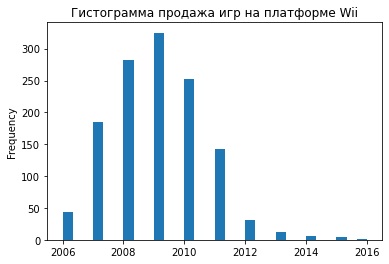

In [289]:
data_Wii = dataset[dataset['platform'] == 'Wii']
data_Wii.groupby('year_of_release')['all_sales'].agg('sum')
data_Wii['year_of_release'].plot(kind='hist', bins=30).set_title('Гистограмма продажа игр на платформе Wii')

Text(0.5, 1.0, 'Гистограмма продажа игр на платформе DS')

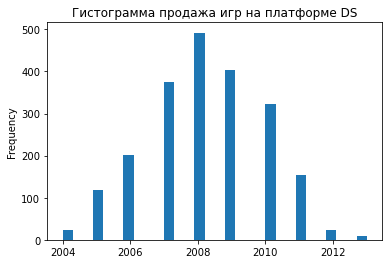

In [290]:
data_DS = dataset[dataset['platform'] == 'DS']
data_DS.groupby('year_of_release')['all_sales'].agg('sum')
data_DS['year_of_release'].plot(kind='hist', bins=30).set_title('Гистограмма продажа игр на платформе DS')

Text(0.5, 1.0, 'Гистограмма продажа игр на платформе PS')

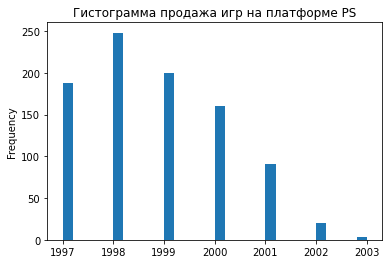

In [291]:
data_PS = dataset[dataset['platform'] == 'PS']
data_PS.groupby('year_of_release')['all_sales'].agg('sum')
data_PS['year_of_release'].plot(kind='hist', bins=30).set_title('Гистограмма продажа игр на платформе PS')

Text(0.5, 1.0, 'Гистограмма продажа игр на платформе PS4')

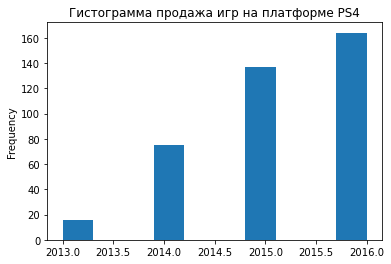

In [292]:
data_PS4 = dataset[dataset['platform'] == 'PS4']
data_PS4.groupby('year_of_release')['all_sales'].agg('sum')
data_PS4['year_of_release'].plot(kind='hist', bins=10).set_title('Гистограмма продажа игр на платформе PS4')

Text(0.5, 1.0, 'Гистограмма продажа игр на платформе GBA')

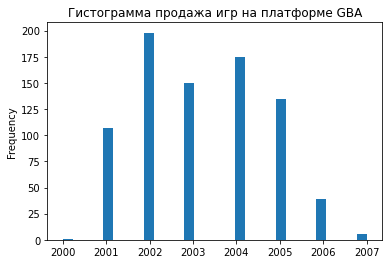

In [293]:
data_GBA = dataset[dataset['platform'] == 'GBA']
data_GBA.groupby('year_of_release')['all_sales'].agg('sum')
data_GBA['year_of_release'].plot(kind='hist', bins=30).set_title('Гистограмма продажа игр на платформе GBA')

Text(0.5, 1.0, 'Гистограмма продажа игр на платформе PSP')

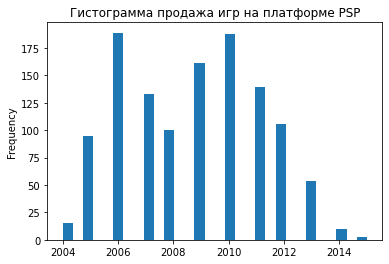

In [294]:
data_PSP = dataset[dataset['platform'] == 'PSP']
data_PSP.groupby('year_of_release')['all_sales'].agg('sum')
data_PSP['year_of_release'].plot(kind='hist', bins=30).set_title('Гистограмма продажа игр на платформе PSP')

Text(0.5, 1.0, 'Гистограмма продажа игр на платформе 3DS')

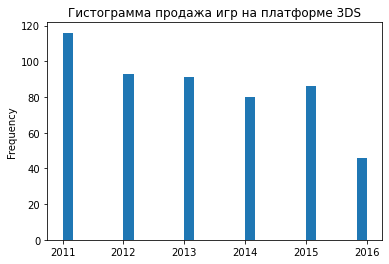

In [295]:
data_3DS = dataset[dataset['platform'] == '3DS']
data_3DS.groupby('year_of_release')['all_sales'].agg('sum')
data_3DS['year_of_release'].plot(kind='hist', bins=30).set_title('Гистограмма продажа игр на платформе 3DS')

Text(0.5, 1.0, 'Гистограмма продажа игр на платформе XB')

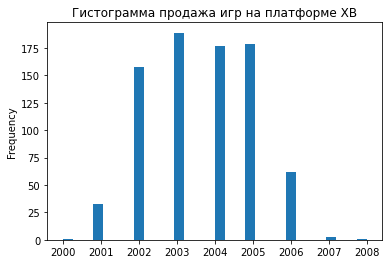

In [296]:
data_PSP = dataset[dataset['platform'] == 'XB']
data_PSP.groupby('year_of_release')['all_sales'].agg('sum')
data_PSP['year_of_release'].plot(kind='hist', bins=30).set_title('Гистограмма продажа игр на платформе XB')

Text(0.5, 1.0, 'Гистограмма продажа игр на платформе PC')

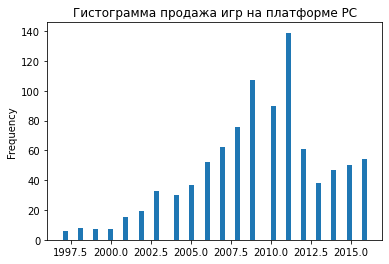

In [297]:
data_PC = dataset[dataset['platform'] == 'PC']
data_PC.groupby('year_of_release')['all_sales'].agg('sum')
data_PC['year_of_release'].plot(kind='hist', bins=60).set_title('Гистограмма продажа игр на платформе PC')

Большинство популярных платформ уже не котируются и скажем так "умерли": PS2, Wii (практически), DS, PS, GBA, PSP, XB. Остальные платформы живы и пока существуют. Платформа ПК начала набирать популярностьс 2000х годов ( все-таки компьютер был ранее достаточно дорогим удовольствием, и многие покупали поративные консоли я считаю). После 2011 г. ПК опять начали терять попуплярность, люди пошли на xbox и плойки плюс нинтендо. Можно обратить внимание на PS4 - как она стартанула, дальше наверняка увидим ее в лидерах.

В среднем если посмотреть то платформы, которые вышли из оборота просуществовали порядка 10ти лет.

###  Анализ актуальных игровых платформ

Из предыдущего пункта мы узнали, что в среднем платформы живут 10 лет, произведем расчет на основании этих данных, то есть возьмем для анализа данные с 2007 года ( как раз отбросим "мертвые платформы").

In [298]:
dataset=dataset[dataset['year_of_release'] > 2012]

Возьмем период для исследования с 2013 г. ( считаю так мы захватим часть старых платформ, которые еще живы и барахтаются) и учтем появление новых, таких как PS4 и Xbox One. Плюс в описании проекта написано, что данные на декабрь 2016 г., то есть данных на конец 2016 г. нет).

Еще один момент, почему я хочу захватить старые платформы: на них мы можем узнать какие игроки в какие жанры играют - и учесть это. Ведь если эти платформы "умрут" ( а они умрут так или иначе), чтобы мы знали какие жанры прибавятся на существующих платформах. Поясню: если человек играл в шутеры на ps2, то после ухода с рынка ps2 человек при переходе на новую платформу ( 

Сгруппируем данные по платформам:

In [299]:
pivot_dataset_platform_actual=pd.pivot_table(dataset,index=['year_of_release'], columns='platform',values='all_sales', aggfunc='sum').reset_index()

display(pivot_dataset_platform_actual.head(10))

platform,year_of_release,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
0,2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
1,2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2,2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
3,2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


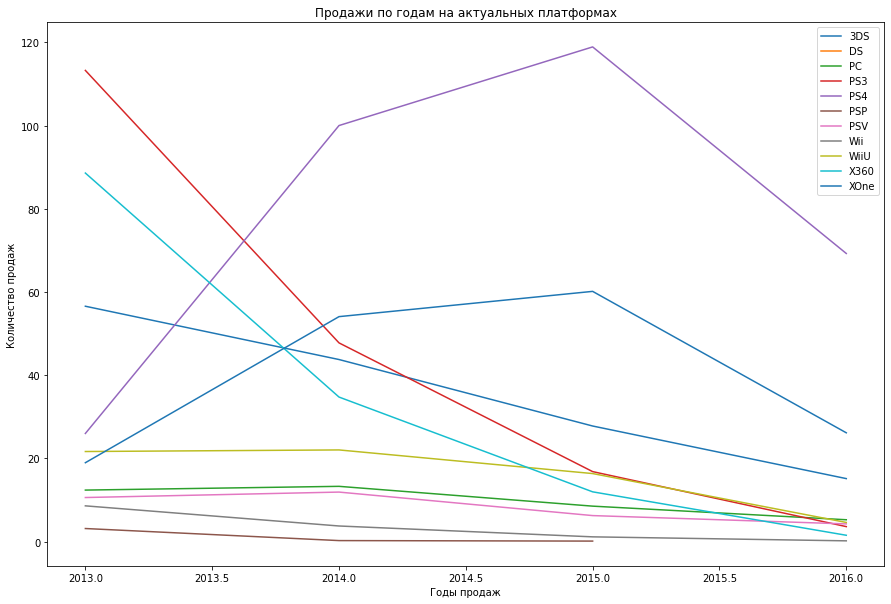

In [300]:
plt.figure(figsize=(15,10))
plt.grid()
plt.title('Продажи по годам на актуальных платформах')

i=0
for column in pivot_dataset_platform_actual.columns[1:]:
    plt.plot(pivot_dataset_platform_actual.year_of_release.to_list(), pivot_dataset_platform_actual[column].to_list(), label=column);
    i+=1

plt.grid()
plt.xlabel('Годы продаж')    
plt.ylabel('Количество продаж')
plt.legend()
plt.show()

Получаем, что самые прибыльные платформы на 2017 год - это PS4 ( новая игровая консоль) и XOne ( так же новая игровая консоль). Продажи на ПК так же значительно пошли на спад, но сбрасывать со счетов не стоит, так же как и 3DS. 

Итог: PS4, XOne, DS и PC (я думаю не стоит огорчять ПК-боярь :-))

Посмотрим на продажи игр по платформам:

Text(0.5, 0.98, 'Продажи по платформам')

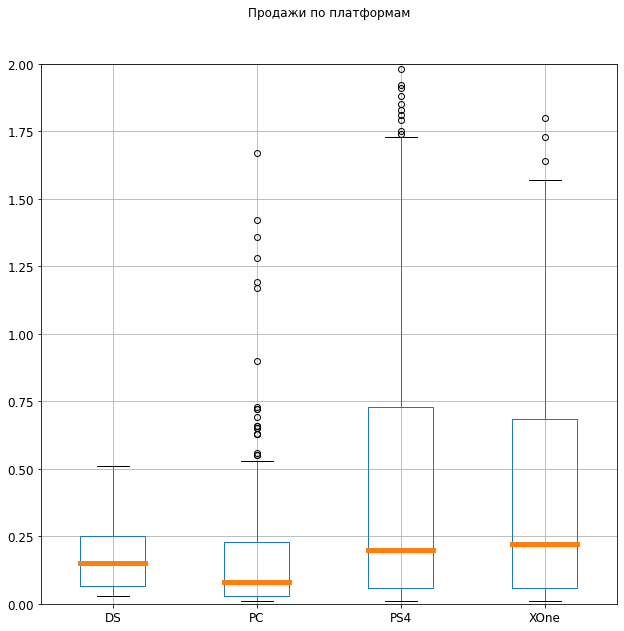

In [301]:
ax = dataset[(dataset['platform'] == 'PS4') | 
             (dataset['platform'] == 'XOne') | 
             (dataset['platform'] == 'DS') | 
             (dataset['platform'] == 'PC')].boxplot(column='all_sales', by='platform', 
                                                    fontsize=12,medianprops=dict(linestyle='-', linewidth=5),figsize=(10,10))
ax.set_title('')
ax.title.set_size(40)
ax.set_xlabel('')
ax.set_ylim(0, 2)
plt.suptitle('Продажи по платформам')

Можем сказать следующее: лидерами по продажам видеоигры у нас остались PS4 и XOne - число проданных игр достигает практически 1,75 млн. Эти же платформы лидируют и по медиане продаж ( самая высокая, лидер - Xone - совсем чуть-чуть опередив PS4). Следом расположился DS и замыкает четверку лидеров ПК, но стоит отметить что ПК обгоняет DS по числу проданных игр.

Оценим зависимость продаж игр о ценок критиков и игроков на примере платформы PS4:

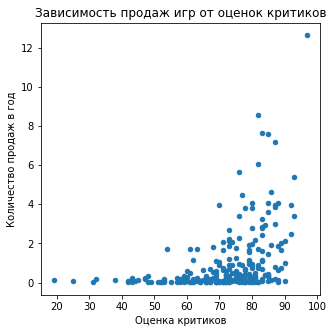

In [302]:
data_PS4.plot(x='critic_score', y='all_sales', kind='scatter', figsize=(5, 5));
plt.xlabel('Оценка критиков')
plt.ylabel('Количество продаж в год')
plt.title('Зависимость продаж игр от оценок критиков');

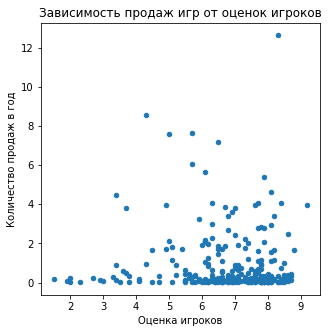

In [303]:
data_PS4.plot(x='user_score', y='all_sales', kind='scatter', figsize=(5,5));
plt.xlabel('Оценка игроков')
plt.ylabel('Количество продаж в год')
plt.title('Зависимость продаж игр от оценок игроков');

In [304]:
data_PS4[['critic_score','user_score','all_sales']].corr()

,critic_score,user_score,all_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
all_sales,0.406568,-0.031957,1.000000


Мы это предполагали, и подтвердили это: зависимость между отзывами критиков и продажей игр имеется, прямопропорциональная, хоть и не такая сильная (0,55 ), а вот отзывы пользователей практически не влияют на продажи.

Посмотрим на корреляцую некоторых других популярных платформ:

In [305]:
print (f"DS:{data_X360[['critic_score','user_score','all_sales']].corr()}")
print (f"PC:{data_PC[['critic_score','user_score','all_sales']].corr()}")

DS:              critic_score  user_score  all_sales
critic_score      1.000000    0.625020   0.392866
user_score        0.625020    1.000000   0.114187
all_sales         0.392866    0.114187   1.000000
PC:              critic_score  user_score  all_sales
critic_score      1.000000    0.552176   0.252997
user_score        0.552176    1.000000   0.007293
all_sales         0.252997    0.007293   1.000000


По рассмотреным платформам так же наблюдается прямопропорциональная связь между оценками критиков и продажами, пусть и не всегда сильная, а вот оценки пользователей практически не влиют на продажию

### Распределение игр по жанрам

Рассмотрим, как игры делятся по жанрам и делятся жанры по продажам:

In [306]:
dataset_genre_kol=dataset.groupby('genre')['name'].count().sort_values()
dataset_genre_kol.head(20)

genre
Puzzle           17
Strategy         56
Simulation       62
Platform         74
Fighting         80
Racing           85
Misc            155
Shooter         187
Sports          214
Adventure       245
Role-Playing    292
Action          766
Name: name, dtype: int64

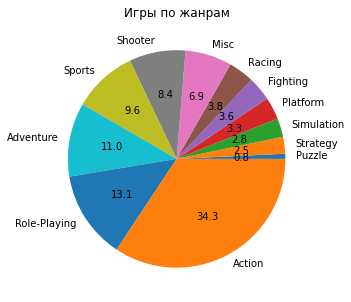

In [307]:
plt.figure(figsize=(5,5))
plt.pie(x=dataset_genre_kol, labels=dataset_genre_kol.index, autopct="%.1f")
plt.title('Игры по жанрам');
plt.show()

In [308]:
dataset_genre_sale=dataset.groupby('genre')['all_sales'].sum().sort_values()
dataset_genre_sale.head(20)

genre
Puzzle            3.17
Strategy         10.08
Simulation       21.76
Adventure        23.64
Fighting         35.31
Racing           39.89
Platform         42.63
Misc             62.82
Role-Playing    145.89
Sports          150.65
Shooter         232.98
Action          321.87
Name: all_sales, dtype: float64

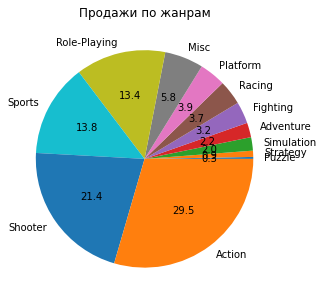

In [309]:
plt.figure(figsize=(5,5))
plt.pie(x=dataset_genre_sale, labels=dataset_genre_sale.index, autopct="%.1f")
plt.title('Продажи по жанрам');
plt.show()

Самые выпускаемые игры по жанрам: Экшены (ожидаемо), <s>музыкальные ( неожиданно для меня)</s>, Ролевые, Приключения и Спорт. А вот в продаваемых играх есть рокировка: на первом месте также Экшены, на второе место вышли Шутеры ( хотя их выпускают всего лишь 8,4 % от общего числа), на третьем месте Спорт и на четвертом Ролевые игры, Приключения практически не покупают.

### Вывод

* Расцвет видеоигр начался в 1995 году и по сей дей они очень популярны. В 2010 г. наблюдался всплеск по выпуску игр, после чего пошло постепенное уменьшение в количестве выпускаймых тайтлов ( наверное пользователи стали более превередливыми и издатели решили брать качеством, а не количеством).
* Игры продавались по той же тенденции, что и выпускались: бум продаж начался в 1996 году и достиг пика в 2008 г, затем произошло постепенное снижение продаж.
* За 20 лет развития игровой идустрии появлялись (которые мы рассматриваем), появлялись и развивались разные виды игровых платформ,которые полюбились в свое время пользователям, но получается так, что в среднем игровая платформа живет 10 лет ( я не буду здесь говорить о ПК, они мне кажется будут жить вечно, однако мощный компьютер дорогое удовольствие и сыграть в последний ААА проект бывает очень затратно - это ведь надо купить новую видеокарту, процессор и пр., поэтому возможно и ПК скоро вытяснят). Самые популярные платформы PS4, XOne, DS и PC - на них строит сделать упор в 2017 г.
* Продажи игр на современных платформах имеют прямопропорциональную зависимость от оценки критиков ( пусть она и не очень сильная, но все же есть), а вот как показал анализ оценки пользователей мало влияют на продажи.
* Самые выпускаемые жанры это Экшены, <s>Музыкальные</s>, Ролевые, Приключения и Спортивные игры. А вот самые продаваемые немного дургие: Экшены, Шутеры, Спортивные и Ролевые. Возможно стоит уделить вниманеи шутерам - делают их мало, а продаются они хорошо.


## Портрет пользователя каждого региона

### Самые популярные платформы (топ-5)

In [310]:
dataset_region_na=dataset.groupby('platform')['na_sales'].sum().sort_values().reset_index()
dataset_region_na.columns = ['platform', 'na_sales']
dataset_region_na=dataset_region_na[dataset_region_na['na_sales'] > 30]
dataset_region_na.head(20)

,platform,na_sales
6,3DS,38.20
7,PS3,63.50
8,X360,81.66
9,XOne,93.12
10,PS4,108.74


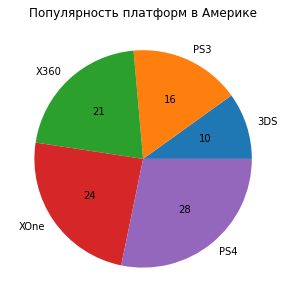

In [311]:
plt.figure(figsize=(5,5))
plt.pie(x=dataset_region_na['na_sales'], labels=dataset_region_na['platform'], autopct="%1.0f")
plt.title('Популярность платформ в Америке');
plt.show()

<s>В Америке особую популярность имеет платформа Икс Бокс X360, на втором месте расположился Wii и третьем соответсвенно PS3.</s>

<div class="alert alert-block alert-info">
<b>КОММЕНТАРИЙ ОТ УЧЕНИКА: </b>
    
После изменения актуального периода вывод поменялся: Самая популярная платформа в Америке - это PS4, следом идут Xone и X360, PS3 и 3DS - замыкают пятерку лидеров в данном регионе.
</div>

In [312]:
dataset_region_eu=dataset.groupby('platform')['eu_sales'].sum().sort_values().reset_index()
dataset_region_eu.columns = ['platform', 'eu_sales']
dataset_region_eu=dataset_region_eu[dataset_region_eu['eu_sales'] > 30]
dataset_region_eu.head(20)

,platform,eu_sales
6,3DS,30.96
7,X360,42.52
8,XOne,51.59
9,PS3,67.81
10,PS4,141.09


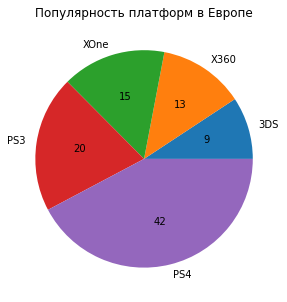

In [313]:
plt.figure(figsize=(5,5))
plt.pie(x=dataset_region_eu['eu_sales'], labels=dataset_region_eu['platform'], autopct="%1.0f")
plt.title('Популярность платформ в Европе');
plt.show()

В Европе в лидеры с существенным перевесом вырвалась новая игровая платформа PS4 ( новая на исследуемый период), на втором и третьем месте оказались PS3 и XOne соответственно. В целом набор платформ остался таким же, произошла их рокировка просто.

In [314]:
dataset_region_jp=dataset.groupby('platform')['jp_sales'].sum().sort_values().reset_index()
dataset_region_jp.columns = ['platform', 'jp_sales']
dataset_region_jp=dataset_region_jp[dataset_region_jp['jp_sales'] > 5]
dataset_region_jp.head(20)

,platform,jp_sales
6,WiiU,10.88
7,PS4,15.96
8,PSV,18.59
9,PS3,23.35
10,3DS,67.81


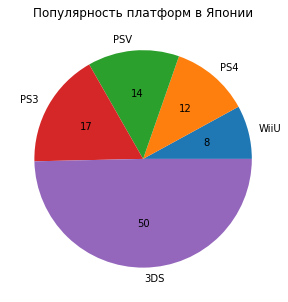

In [315]:
plt.figure(figsize=(5,5))
plt.pie(x=dataset_region_jp['jp_sales'], labels=dataset_region_jp['platform'], autopct="%1.0f")
plt.title('Популярность платформ в Японии');
plt.show()

В Япоснком регионе рокировка сил существенная, здесь за наблюдаемый период в лидеры выбилась платформа 3DS, которая завоевала 50% рынка, на втором и третьем месте PS3 и PSV (была у меня ПСВита, но я так не понял ее прелести). PS4 и WiiU замыкают пятерку лидеров.


Рынки Европы, Америки и Японии существенно отличаются по игровым платформам. И если Америкак и Европа схожи в части набора платформ ( небольшие рокировки в процентном соотношении), то в Японии все все по другому.

### Самые популярные жанры (топ-5)

In [316]:
dataset_genre_na=dataset.groupby('genre')['na_sales'].sum().sort_values().reset_index()
dataset_genre_na.columns = ['genre', 'na_sales']
dataset_genre_na=dataset_genre_na[dataset_genre_na['na_sales'] > 25]
dataset_genre_na.head(20)

,genre,na_sales
7,Misc,27.49
8,Role-Playing,46.40
9,Sports,65.27
10,Shooter,109.74
11,Action,126.05


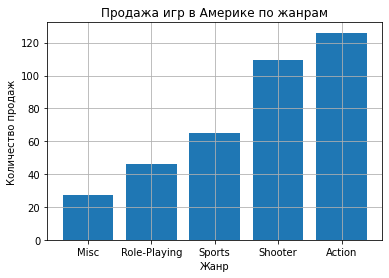

In [317]:
fig, ax = plt.subplots()
ax.bar(dataset_genre_na['genre'], dataset_genre_na['na_sales'])
plt.xlabel('Жанр')
plt.ylabel('Количество продаж')
plt.grid()
plt.title('Продажа игр в Америке по жанрам')
plt.show()

В Америке игроки отдают предпочтение Экшенам ( они уверенно лидируют), следом идут с незначительными различиями идут Шутеры и Спорт. Ролевые и музыкальные игры закрывают популярные жанры.

In [318]:
dataset_genre_eu=dataset.groupby('genre')['eu_sales'].sum().sort_values().reset_index()
dataset_genre_eu.columns = ['genre', 'eu_sales']
dataset_genre_eu=dataset_genre_eu[dataset_genre_eu['eu_sales'] > 20.10]
dataset_genre_eu.head(20)

,genre,eu_sales
7,Racing,20.19
8,Role-Playing,36.97
9,Sports,60.52
10,Shooter,87.86
11,Action,118.13


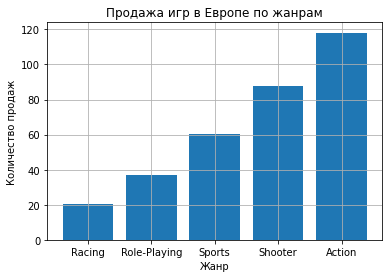

In [319]:
fig, ax = plt.subplots()
ax.bar(dataset_genre_eu['genre'], dataset_genre_eu['eu_sales'])
plt.xlabel('Жанр')
plt.ylabel('Количество продаж')
plt.grid()
plt.title('Продажа игр в Европе по жанрам')
plt.show()

Европейские геймеры по жанрам практически не отличаются от своих собратьев из Америки, единственное что на пятое место поднялись гонки.

In [320]:
dataset_genre_jp = dataset.groupby('genre')['jp_sales'].sum().sort_values().reset_index()
dataset_genre_jp.columns = ['genre', 'jp_sales']
dataset_genre_jp=dataset_genre_jp[dataset_genre_jp['jp_sales'] > 6]
dataset_genre_jp.head(20)

,genre,jp_sales
7,Shooter,6.61
8,Fighting,7.65
9,Misc,9.20
10,Action,40.49
11,Role-Playing,51.04


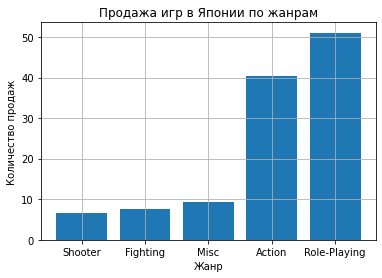

In [321]:
fig, ax = plt.subplots()
ax.bar(dataset_genre_jp['genre'], dataset_genre_jp['jp_sales'])
plt.xlabel('Жанр')
plt.ylabel('Количество продаж')
plt.grid()
plt.title('Продажа игр в Японии по жанрам')
plt.show()

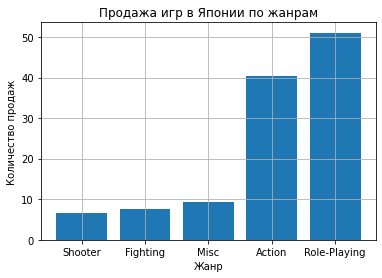

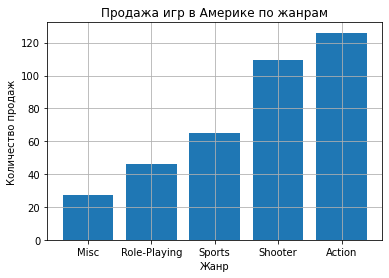

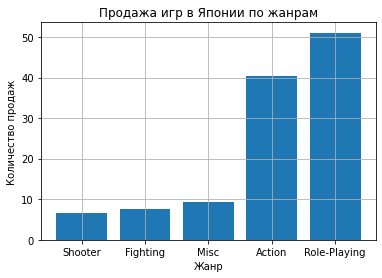

In [322]:
fig, ax3 = plt.subplots()
ax3.bar(dataset_genre_jp['genre'], dataset_genre_jp['jp_sales'])
plt.xlabel('Жанр')
plt.ylabel('Количество продаж')
plt.grid()
plt.title('Продажа игр в Японии по жанрам')
plt.show()
fig, ax2 = plt.subplots()
ax2.bar(dataset_genre_na['genre'], dataset_genre_na['na_sales'])
plt.xlabel('Жанр')
plt.ylabel('Количество продаж')
plt.grid()
plt.title('Продажа игр в Америке по жанрам')
plt.show()
fig, ax3 = plt.subplots()
ax3.bar(dataset_genre_jp['genre'], dataset_genre_jp['jp_sales'])
plt.xlabel('Жанр')
plt.ylabel('Количество продаж')
plt.grid()
plt.title('Продажа игр в Японии по жанрам')
plt.show()

Японский рынок игр как всегда выделился: на первое место с уверенным отрывом вышли ролевые игры, дальше идут Экшены, Музыкальный жанр и Файтинги, шутеры закрывают пятерку лидеров.


Вкусы в играх совпадают в Европе и Америке, в обоих регионах уверенно лидируют три жанра: экшн, шутеры и спорт. Япония так же любит экшены, однако они на втором месте, уступив первое место ролевым играм, и третья позиця отличается от Америки с европой - японцы любят петь.

### Влияние рейтинга ESRB на продажи по регионам

Соберем данные по возврастным ограничениям в одну таблицу:

In [323]:
dataset_rating = dataset.groupby('rating')['na_sales', 'eu_sales', 'jp_sales'].sum().sort_values(by='jp_sales').reset_index()
dataset_rating.head(10)

,rating,na_sales,eu_sales,jp_sales
0,E10+,54.24,42.69,5.89
1,M,165.21,145.32,14.11
2,E,79.05,83.36,15.14
3,T,49.79,41.95,20.59


Расшифровка рейтингов:\
E - для всех возрастных групп \
E10+ - для лиц страше 10+\
EC - для детей маленького возраста\
M - для взрослых\
RP - рейтинг еще не объявлен\
T - для подростков

Игры для всех возврастных групп самые распространенные во всех регионах, жто и не удивительно - ни один издатель не хочется потерять денег при продажах и делает игры такими, чтобы они смогли охватить как можно большую возврастную категорию лиц. Второе место занимают игры для взрослых( в Европе и Америке), а вот в Японии на втором месте расположились игры для поздростков.Третье место в Америке и Европе поменялись местами с Японией. Доля игр других категорий крайне мала, чтобы учитывать их в анализе.

### Вывод

* В Америке и Европе лидеры по платформам похожи: PS4 - лидер в этих регионах, незначительные изменения по платформам второго и третьего места: XOne и X360 и PS3. В Японии лидеры рынка платформ поменялись: 3DS - главный лидер (50%), следом идут PS3 и PSV.
* Самые популярные жанры по регионам: это экшены, шутеры и спортивные игры. Свои коррективы вносит Японский регион: здесь на первое место выходят ролевые игры и увеличивается дола музыкальных тайтлов.

## Проверка гипотиз

### Средние пользовательские рейтинги платформ Xbox и PC одинаковые

Сформулируем гипотезы:
* Нулевая гипотеза(H0): средние пользовательские рейтинги платформ Xbox One и PC одинаковые 
* Альтернативная гипотеза (Н1): средние пользовательские рейтинги платформ Xbox One и PC отличаются

In [324]:
dataset_xbox=dataset[(dataset['platform'] == "XOne")]
dataset_xbox.dropna(subset=['user_score'], inplace=True)
dataset_xbox=dataset_xbox['user_score']

dataset_pc=dataset[(dataset['platform'] == "PC")]
dataset_pc.dropna(subset=['user_score'], inplace=True)
dataset_pc=dataset_pc['user_score']

alpha = .05 
results = st.ttest_ind(
    dataset_xbox, 
    dataset_pc)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


In [325]:
print('Средняя оценка пользователей XOne:',dataset_xbox.mean())
print('Средняя оценка пользователей PC:',dataset_pc.mean())

Средняя оценка пользователей XOne: 6.52142857142857
Средняя оценка пользователей PC: 6.269677419354836


Расчеты говорят нам, что мы можем не отвергать нулевую гипотезу и предполагать, что среднии оценки пользователей по платформам равны.

### Средние пользовательские рейтинги жанров Action и Sports разные

Сформулируем гипотезы:
* Нулевая гипотеза(H0): Средние пользовательские рейтинги жанров Action и Sports одинаковые 
* Альтернативная гипотеза (Н1): Средние пользовательские рейтинги жанров Action и Sports разные

In [326]:
dataset_action=dataset[(dataset['genre'] == "Action")]
dataset_action.dropna(subset=['user_score'], inplace=True)
dataset_action=dataset_action['user_score']

dataset_sports=dataset[(dataset['genre'] == "Sports")]
dataset_sports.dropna(subset=['user_score'], inplace=True)
dataset_sports=dataset_sports['user_score']

alpha = .05 
results = st.ttest_ind(
    dataset_action, 
    dataset_sports)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.0517832389140023e-27
Отвергаем нулевую гипотезу


In [327]:
print('Средняя оценка пользователей игр жанра Action:' ,dataset_action.mean())
print('Средняя оценка пользователей игр жанра Sports:' ,dataset_sports.mean())

Средняя оценка пользователей игр жанра Action: 6.837532133676097
Средняя оценка пользователей игр жанра Sports: 5.238124999999999


Пользовательские оценки по жанрам отличаются, значит можем предположить, что нулевая гипотеза может быть отвергнута и мы можем сказать: Средние пользовательские рейтинги жанров Action и Sports разные

## Общий вывод

1. Предобработка данных:
* Мы привели написание столбцов к нижнему регистру: теперь это смотрится аккуратно и красиов.
* Выяснили, что дубликатов и неявных дубликатов нет.
* Превели необходимы нам столбцы к нужным типам: float64 И Int64.
* Пропуски по столбцам critic_score, user_score, rating и year_of_release оставили как есть, так как не нашли адекватной возможности найти замену пропускам.
* Посчитали полную выручку по всем каналам продаж для каждой игры

2. Исследовательский анализ данных:
* Расцвет видеоигр начался в 1995 году и по сей дей они очень популярны. В 2010 г. наблюдался всплеск по выпуску игр, после чего пошло постепенное уменьшение в количестве выпускаймых тайтлов ( наверное пользователи стали более превередливыми и издатели решили брать качеством, а не количеством).
* Игры продавались по той же тенденции, что и выпускались: бум продаж начался в 1996 году и достиг пика в 2008 г, затем произошло постепенное снижение продаж.
* За 20 лет развития игровой идустрии появлялись (которые мы рассматриваем), появлялись и развивались разные виды игровых платформ,которые полюбились в свое время пользователям, но получается так, что в среднем игровая платформа живет 10 лет ( я не буду здесь говорить о ПК, они мне кажется будут жить вечно, однако мощный компьютер дорогое удовольствие и сыграть в последний ААА проект бывает очень затратно - это ведь надо купить новую видеокарту, процессор и пр., поэтому возможно и ПК скоро вытяснят). Самые популярные платформы -PS4, XOne,PC и добилась платформа DS.
* Продажи игр на современных платформах имеют прямопропорциональную зависимость от оценки критиков ( пусть она и не очень сильная, но все же есть), а вот как показал анализ оценки пользователей мало влияют на продажи.
* Самые выпускаемые жанры это Экшены, Ролевые, Приключения и Спортивные игры. А вот самые продаваемые немного дургие: Экшены, Шутеры, Спортивные и Ролевые. Возможно стоит уделить вниманеи шутерам - делают их мало, а продаются они хорошо.

3. Портрет пользователя каждого региона:
* В Америке и Европе лидеры по платформам похожи: PS4 - лидер в этих регионах, незначительные изменения по платформам второго и третьего места: XOne и X360 и PS3. В Японии лидеры рынка платформ поменялись: 3DS - главный лидер (50%), следом идут PS3 и PSV.
* Самые популярные жанры по регионам: это экшены, шутеры и спортивные игры. Свои коррективы вносит Японский регион: здесь на первое место выходят ролевые игры и увеличивается дола музыкальных тайтлов.
* Поизводители игр во всех регионах стараются делать игры для взрослых и для всех возврастных групп, чтобы охватить как можно больше людей.
4. Проверка гипотиз:
* Средние пользовательские рейтинги платформ Xbox и PC одинаковые
* Средние пользовательские рейтинги жанров Action и Sports разные